In [1]:
suppressMessages(here::i_am('R_analysis/notebooks/SI_climate_data_comparison.ipynb'))
CODE = here::here()
source(glue::glue("{CODE}/R_analysis/init.R"))

Loading required package: pacman



In [6]:
local_load('analysis/clean_data.R')
# Load arguments
local_load('analysis/main_analysis_args.R')

In [165]:
crop='corn'

df = lapply(c('prism', 'era5', 'gmfd'), load_panel, crop='corn')

In [11]:
test = df

In [168]:
clims = c('prism', 'era5', 'gmfd')

In [169]:
for (i in c(1,2,3)) {
    df[[i]] = df[[i]] |> 
        select(fips, year, state, dday30C, tavg, t, t2) |>
        mutate(source = clim[i])
}

In [72]:
plot_df = bind_rows(df)
plot_df$crop = 'corn'
shp_dir = '/home3/dth2133/data/shapefiles/county/cb_2018_us_county_500k.shp'

In [73]:
plot_df = plot_df |> mutate(tavg = ifelse(source=='era5', tavg - 273.15, tavg))

In [74]:
plot_df = plot_df |> select(-year, -state, -t, -t2) |> group_by(fips, source, crop) |> summarize_all(mean)

In [71]:
crop

[1] NA

In [75]:
shp = st_read(shp_dir)

shp = shp |> 
    filter(!STATEFP %in% c(
        "02","15", "60",
        "66","72","78", "69")) |>
    mutate(fips=as.numeric(GEOID)) |> 
    select(fips, geometry)

# This loop is annoyingly slow, but necessary to get
# polygons w/o crops included for each crop-source combo
plot_gdf = data.frame()
for (crop in unique(plot_df$crop)) {
    for (source in unique(plot_df$source)) {
        plot_gdf = bind_rows(
            plot_gdf,
            plot_df |>
                filter(crop==!!crop, source==!!source) |>
                right_join(shp, by='fips') |>
                mutate(
                    centroid = st_centroid(geometry), 
                    longitude = st_coordinates(centroid)[, 1],
                    latitude = st_coordinates(centroid)[, 2],
                    crop = !!crop,
                    source = !!source
                ) |>
                select(-centroid, -geometry) |>
                filter(longitude > -100)
        )
    }
}

plot_df = shp |> right_join(plot_gdf, by='fips')



Reading layer `cb_2018_us_county_500k' from data source 
  `/home3/dth2133/data/shapefiles/county/cb_2018_us_county_500k.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 3233 features and 9 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -179.1489 ymin: -14.5487 xmax: 179.7785 ymax: 71.36516
Geodetic CRS:  NAD83


In [76]:
plot_df$source = factor(
    plot_df$source,
    levels = c('prism', 'era5', 'gmfd'),
    labels = c('PRISM', 'ERA5-Land', 'GMFD')
)
plot_df$crop = factor(
    plot_df$crop,
    levels = c('corn', 'soy'),
    labels = c('Corn', 'Soybeans')
)

In [85]:
min(plot_df$tavg, na.rm=T)

[1] 9.255516

In [138]:


# Topcode (bottomcode?) results. This only affects a handful of 
# regions and makes plots more consistent and readable
# plot_df = plot_df |> mutate(impact = ifelse(impact2 < -0.5, -0.5, impact2))

plot = ggplot() +
    geom_sf(data=plot_df, aes(fill = tavg)) +
    scale_fill_gradient2(
        high="#e34a33", low='#fee8c8', mid='#fdbb84', midpoint=mean(c(8, 27)),
        limits= c(8, 27), breaks=seq(10,25,5)
    ) + 
    facet_grid2(vars(source)) +
    labs(fill="", title="Avg. temperature") +
    guides(fill = guide_colorbar(barwidth = unit(7, "cm"))) +
    theme_classic() + 
    theme(
        legend.direction = "horizontal",
        legend.position='bottom',
        axis.title = element_blank(),  # Remove axis titles
        axis.text = element_blank(),   # Remove axis text labels
        axis.ticks = element_blank(),   # Remove axis ticks
        panel.grid = element_blank(),   # Remove grid lines
        axis.line = element_blank(),
        text = element_text(size = 16),
        plot.title = element_text(hjust = 0.5))

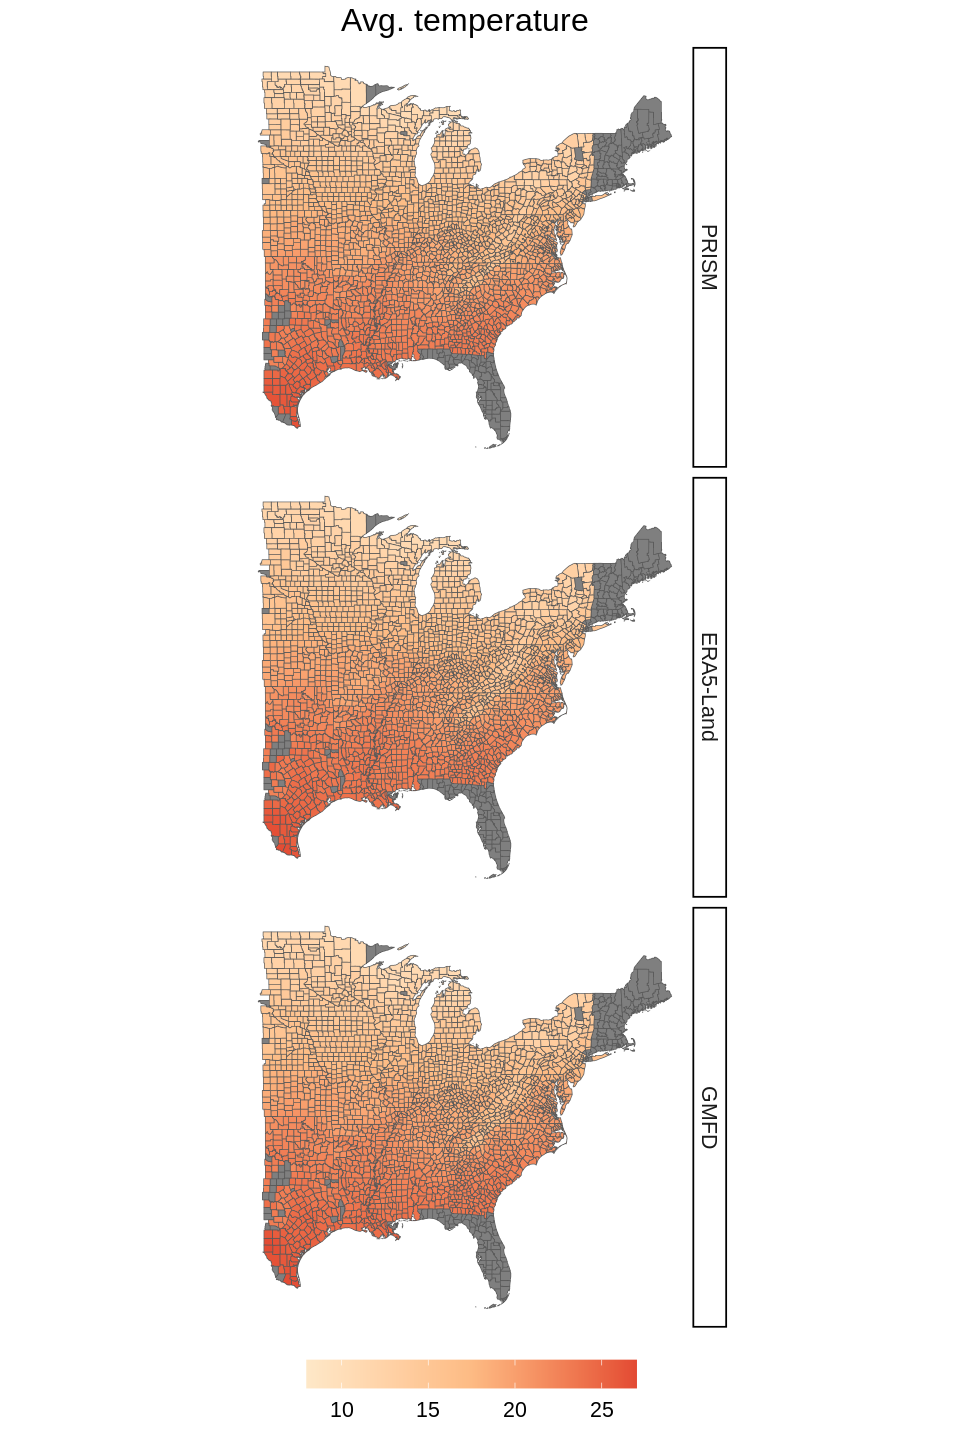

In [139]:
options(repr.plot.width = 8, repr.plot.height = 12)
plot

In [99]:
max(plot_df$dday30C, na.rm=T)

[1] 294.7198

In [105]:
summary(plot_df$dday30C)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   9.403  28.024  40.861  61.187 294.720     640 

In [110]:
max_plot_df = plot_df |> mutate(dday30C = ifelse(dday30C > 200, 200, dday30C))

In [148]:
plot2 = ggplot() +
    geom_sf(data=max_plot_df, aes(fill = dday30C)) +
    scale_fill_gradient2(
        high="#8856a7", low='#e0ecf4', mid='#9ebcda', midpoint=20,
        limits= c(0, 200), breaks=seq(0,200,50)
    ) + 
    facet_grid2(vars(source), switch="both") +
    labs(fill="", title="Degree days >30°C") +
    guides(fill = guide_colorbar(barwidth = unit(7, "cm"))) +
    theme_classic() + 
    theme(
        legend.direction = "horizontal",
        legend.position='bottom',
        axis.title = element_blank(),  # Remove axis titles
        axis.text = element_blank(),   # Remove axis text labels
        axis.ticks = element_blank(),   # Remove axis ticks
        panel.grid = element_blank(),   # Remove grid lines
        axis.line = element_blank(),
        text = element_text(size = 16),
        plot.title = element_text(hjust = 0.5))

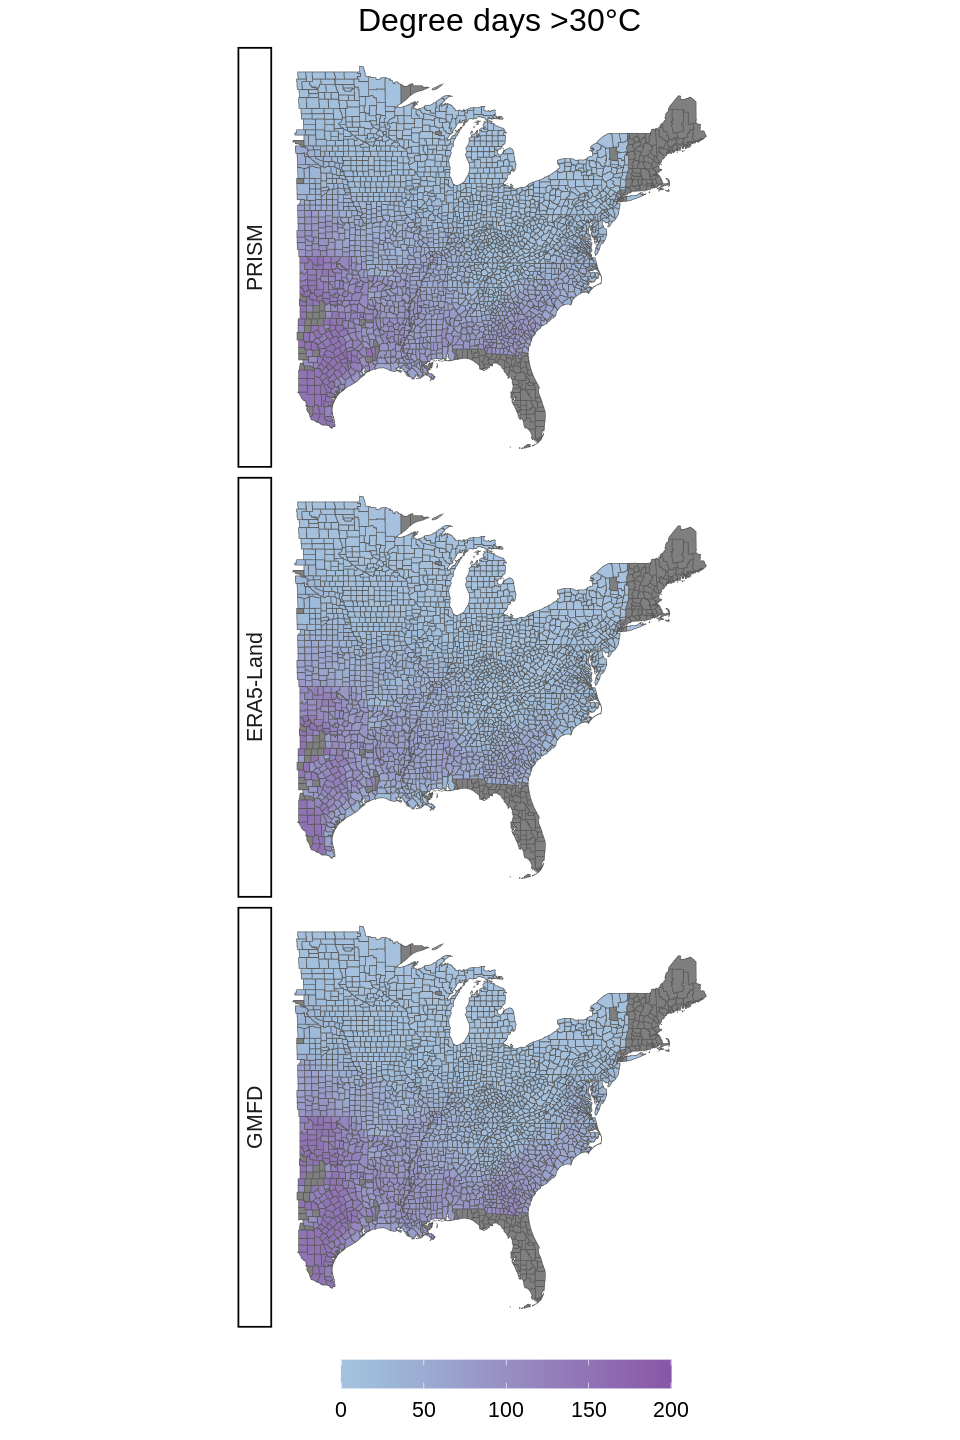

In [149]:
plot2

In [246]:
map = ggarrange(plot2, plot, nrow=1) 

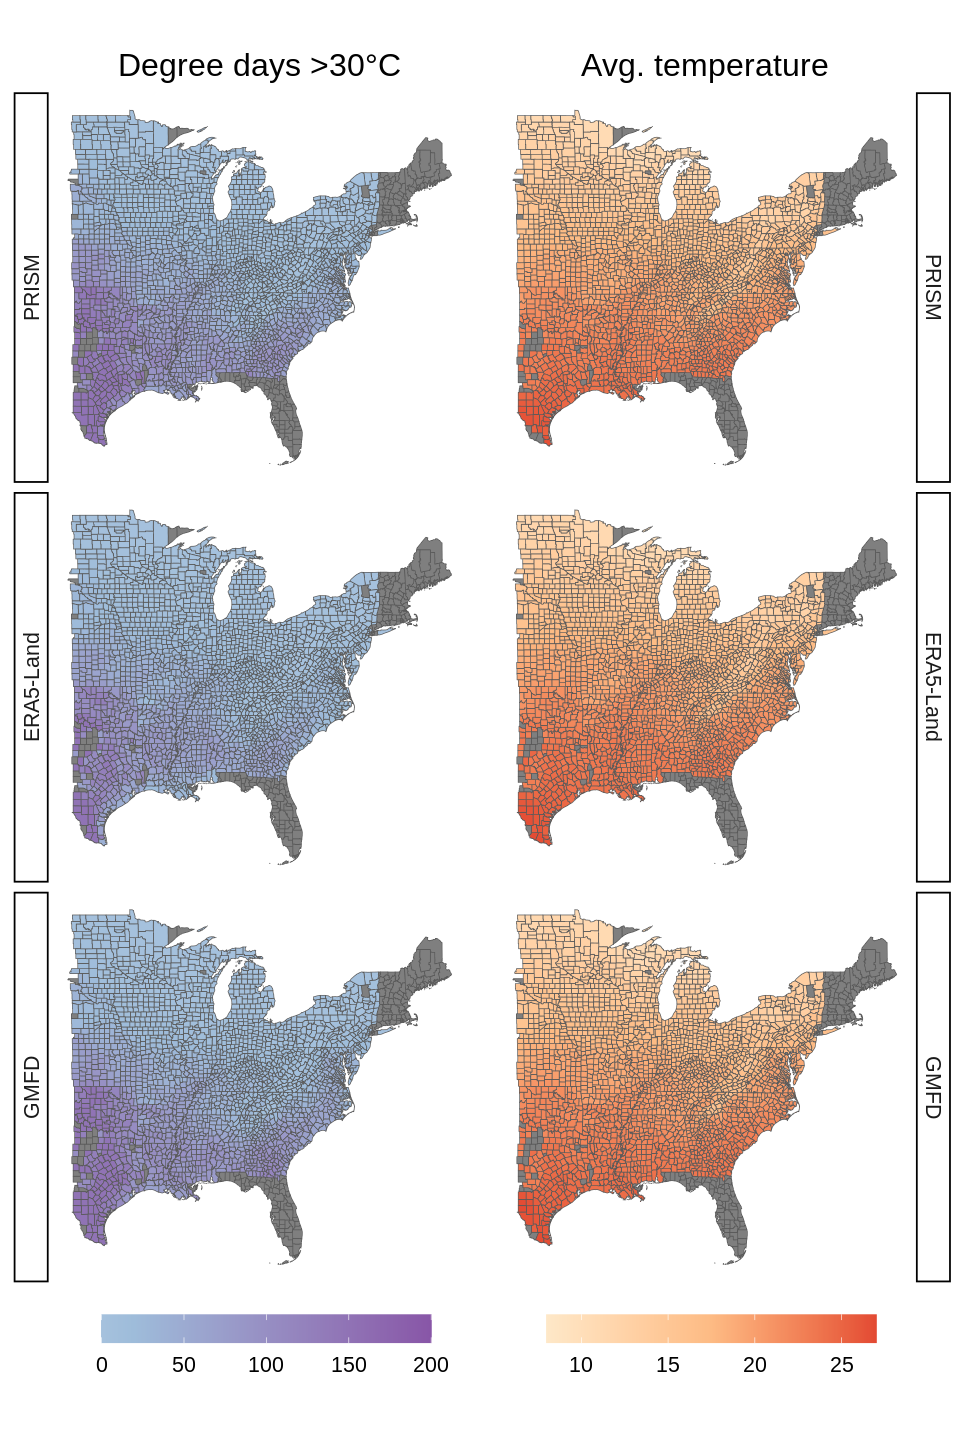

In [248]:
options(repr.plot.width = 8, repr.plot.height = 12)
map

In [249]:
ggsave(glue("{CODE}/results/figures/SI_climate_data_map.png"), map, width=8, height=12)

In [189]:
par_df = bind_rows(df)
par_df = par_df |> pivot_wider(names_from=source, values_from = c(tavg, dday30C, t, t2), id_cols=c(fips, year, state))

for (var in c('tavg', 'dday30C')) {
    for (clim in clims) {
        formula = as.formula(glue("{var}_{clim} ~ 1 | fips + state[t_{clim}] + state[t2_{clim}]"))
        mod = feols(formula, par_df)
        par_df = par_df |> mutate(
            !! glue("{var}_{clim}") := resid(mod, na.rm = FALSE)
        )
    }
}

NOTE: 4,736 observations removed because of NA values (LHS: 4,736, Var. Slopes: 4,736).

NOTE: 13,956 observations removed because of NA values (LHS: 13,956, Var. Slopes: 13,956).

NOTE: 4,736 observations removed because of NA values (LHS: 4,736, Var. Slopes: 4,736).

NOTE: 13,956 observations removed because of NA values (LHS: 13,956, Var. Slopes: 13,956).



,dday30C_era5
dday30C_prism,0.9173308


In [209]:
pc = paste("Partial correlation:", round(cor(par_df[var1], par_df[var2], use="complete.obs"), 4) )

In [210]:
pc

[1] "Partial correlation: 0.9173"

In [212]:
options(repr.plot.width = 7, repr.plot.height = 7)

In [215]:
ld = list(
    gmfd='GMFD',
    era5='ERA5-Land',
    prism='PRISM'
)

In [230]:
for (cg in list(c('prism', 'era5'), c('prism', 'gmfd'), c('era5','gmfd'))) {
    print(cg)
}

[1] "prism" "era5" 
[1] "prism" "gmfd" 
[1] "era5" "gmfd"


In [236]:
plot_list = list()
for (var in c('dday30C')) {
    for (cg in list(c('prism', 'era5'), c('prism', 'gmfd'), c('era5','gmfd'))) {

        clim1=cg[1]
        clim2=cg[2]
        var1 = glue("{var}_{clim1}")
        var2 = glue("{var}_{clim2}")

        grob3 = grobTree(
            textGrob(
                paste("Partial correlation:", round(cor(par_df[var1], par_df[var2], use="complete.obs"), 4) ),
                x = 0.1, y = 0.95, hjust = 0,
                gp = gpar(col = "red", fontsize = 15, fontface = "bold")
            )
        )

        p = ggplot(par_df, aes(x=!! sym(var2), y=!! sym(var1))) + 
            geom_point(alpha=0.5) + 
            ggtitle(glue("{ld[clim1]} vs {ld[clim2]}")) + 
            # geom_text(x=-150, y=150, label=pc) +
            geom_smooth(method=lm, se=FALSE) + 
            scale_x_continuous(name = ld[clim1]) + 
            scale_y_continuous(name = ld[clim2]) + 
            annotation_custom(grob3) + 
            theme(
                plot.title = element_text(hjust = 0.5),
                panel.background = element_blank(),
                axis.line = element_line(color="black"),
                axis.line.x = element_line(color="black"),
                text = element_text(size=16)
            )
        plot_list = c(plot_list, list(p))
    }
}

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 4736 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4736 rows containing missing values (`geom_point()`).”


[[1]]


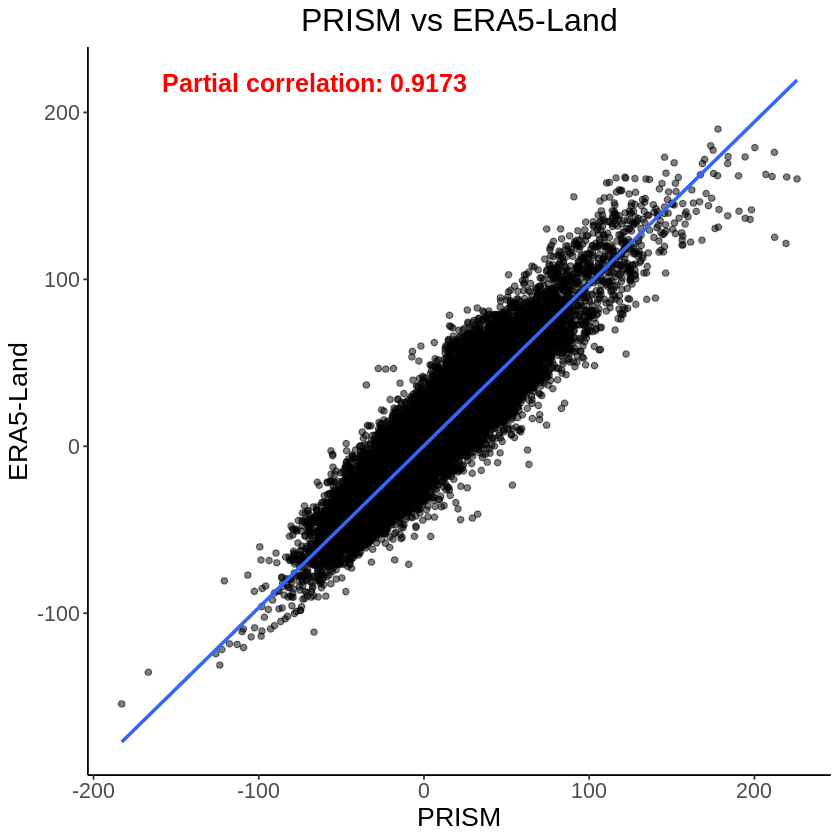

In [237]:
plot_list[1]

In [240]:
options(repr.plot.width = 14, repr.plot.height = 8)
out = ggarrange(plotlist=plot_list, nrow=1) 


`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 4736 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 4736 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 13956 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 13956 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 17150 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 17150 rows containing missing values (`geom_point()`).”


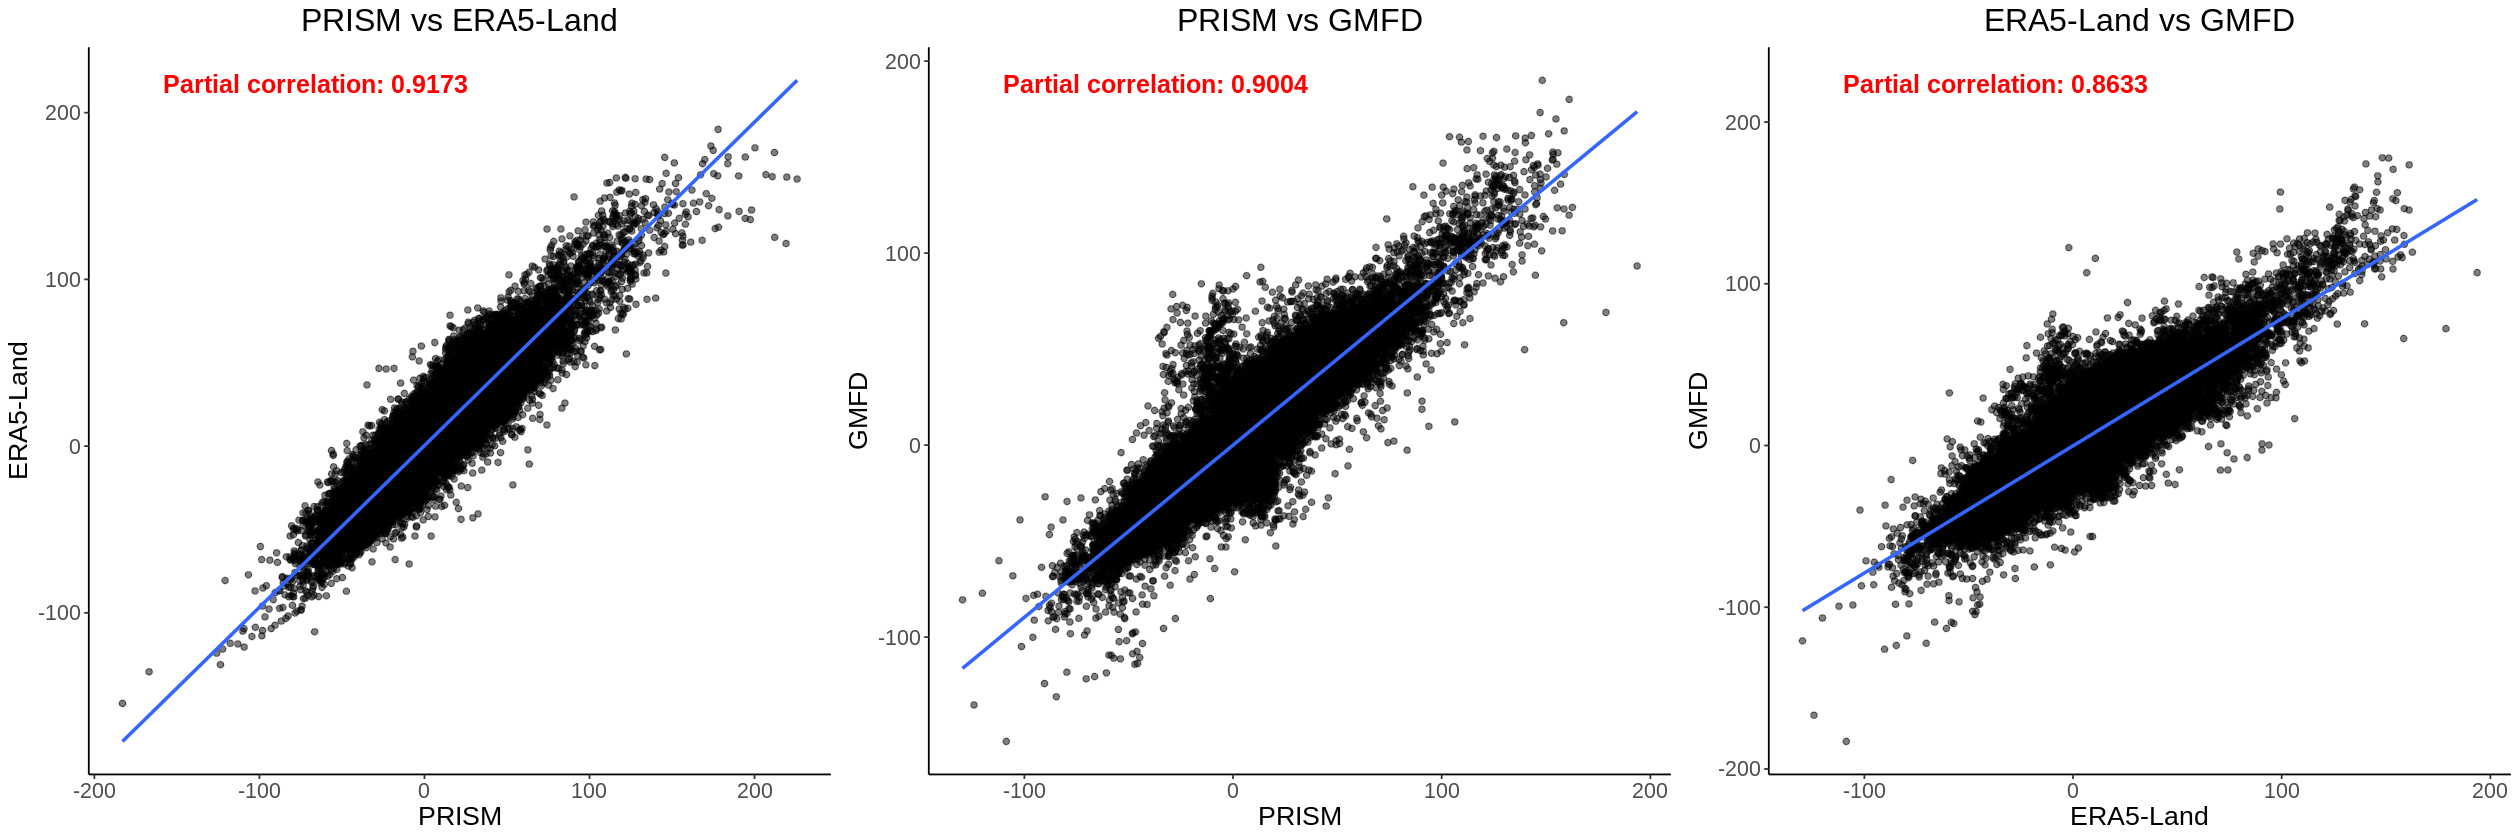

In [242]:
options(repr.plot.width = 21, repr.plot.height = 7)
out

In [245]:
ggsave(glue("{CODE}/results/figures/SI_climate_data_scatter.png"), out, width=21, height=7)

In [ ]:
generate_climate_data_comparison_df = function(